In [87]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib import ticker
import math
import statsmodels
import sklearn
import random
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.stattools import coint
import seaborn as sns
# import hurst
# from hurst import compute_Hc
from IPython.core import display as ICD
import csv
import collections
from collections import OrderedDict, Counter
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
array_1d = Union[List, Tuple, pd.Series, np.ndarray]
date_obj = Union[datetime.datetime, datetime.date]
import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import bs4 as bs
import functools
from hyperopt import hp
import ray
from ray import tune
import logging

import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools import operators as op
from sif.siftools import metrics as metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func

In [76]:
artificial1 = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial1_return.csv')
artificial2 = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial2_return.csv')
bonds = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\bonds_cleaned_return.csv')
crypto = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\crypto_cleaned_return.csv')
equity = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\equity_cleaned_return.csv')
industry = pd.read_csv(r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\IndustrySector_cleaned_return.csv')

In [77]:
bonds.head()

,Unnamed: 0,Dates,006929.OF,004200.OF,050027.OF,002650.OF,100058.OF,100066.OF,006804.OF,004920.OF,...,006985.OF,110037.OF,000205.OF,000032.OF,007169.OF,005705.OF,217022.OF,161713.SZ,002920.OF,380005.OF
0,0,2019-7-16,1.000099,1.000384,0.999909,1.000276,1.000189,1.000280,1.000000,1.000097,...,0.999901,1.0,1.000000,1.000000,1.000298,0.999905,1.000000,1.0,1.000000,1.000000
1,1,2019-7-17,0.999901,0.999904,0.999818,1.000000,1.000000,1.000000,1.000098,0.999903,...,1.000099,1.0,0.999116,1.000000,1.000199,1.000191,1.000000,1.0,1.000094,1.000000
2,2,2019-7-18,0.999901,0.999904,1.000273,1.000092,1.000000,1.000187,1.000098,1.000193,...,1.000297,1.0,1.000885,1.000000,1.000199,1.000191,1.000000,1.0,1.000000,1.000938
3,3,2019-7-19,1.000000,1.000192,0.999635,1.000092,1.000094,1.000280,1.000000,1.000097,...,1.000099,1.0,1.000000,1.000000,1.000199,1.000000,1.000000,1.0,1.000094,1.000000
4,4,2019-7-22,1.000493,1.000384,1.000912,1.000368,1.000189,1.000373,1.000295,1.000386,...,1.000791,1.0,1.000000,1.000829,1.000596,1.000286,1.000703,1.0,1.000283,1.000000


### Helper functions
1. Since we are given returns data, we must reconstruct close price data, so that just takes the cumulative product
2. We have to adjust our backtester to be able to use this format of data as a valid input

In [99]:
def clean_returns(df):
    df = df.drop(columns='Unnamed: 0')
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    return df.cumprod()
    # df_starting_prices = np.array([random.uniform(50, 100) for i in range(len(df_cumprod.columns))]) # i just wanna see if this line matters
    # return df_cumprod * df_starting_prices

In [163]:
def clean_returns2(df):
    df = df.drop(columns='Unnamed: 0')
    df['Dates'] = pd.to_datetime(df['Dates'])
    df = df.set_index('Dates')
    df_cumprod = df.cumprod()
    df_starting_prices = np.array([random.uniform(50, 100) for i in range(len(df_cumprod.columns))]) # i just wanna see if this line matters
    return df_cumprod * df_starting_prices

In [100]:
backtester = fb.FullMultipleBacktester.from_local(r'C:\Users\James Zhang\Desktop\sif\sif\pairstrading\pairs_15y.npy')
fields = backtester.__dict__
fields.keys()

dict_keys(['start_date', 'end_date', 'universe_rebalance_dates', 'max_lookback', 'delay', 'trading_days', 'loaded_data', 'universe_size', 'factors', 'data', 'universes'])

In [161]:
class PairsTrading(AbstractAlpha):
    def __init__(self, reset, npairs, enter, exit, stop, universe_size):
        self.name = 'PairsTrading'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = universe_size
        
        self.pairs = None
        self.print = False
        self.keyPairs = []
        self.reset = reset
        self.npairs = npairs
        self.enter = enter
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
    
    def zscore(self, series):
        return (series - series.mean()) / np.std(series)
    
    def form_pairs(self, df):
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]

        # obtain transformed data and clusters using above functions
        # transformed_data = self.reduce_dimensionality(df)
        # labels = self.cluster_optics(transformed_data)

        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        pairsDict = {} #maps from pvalue to pair
        for i in range(n):
            for j in range(i + 1, n):
                # if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                S1 = df[keys[i]]        
                S2 = df[keys[j]]
                result = coint(S1, S2)
                pvalue = result[1]
                pvalue_matrix[i, j] = pvalue
                
                # used a hashmap, sorted keys (pvalues) in ascending order in order
                # to get the smallest pvalues
                if pvalue < 0.05:
                    pairsDict[(i,j)] = pvalue
        
        # sort the pairs by lowest p-value
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

        # a stock should only be included once in our holdings to prevent mishaps
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        
        # obtain top npairs pairs if possible
        pairs = list(new_dict.keys()) if len(new_dict) < self.npairs else list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    # def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
    #     rets = df.pct_change().dropna()
    #     rets = rets.T
    #     pca = PCA(n_components = 0.9, svd_solver='full')
    #     transformed_data = pca.fit_transform(rets)
    #     return transformed_data
        
    # def cluster_optics(self, transformed_data: array_1d) -> array_1d:
    #     optics = OPTICS(min_samples = 2)
    #     labels = optics.fit_predict(transformed_data)
    #     return labels

    def generate_day(self, day, data):
        
        # creating new pairs
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
      
        data = pd.DataFrame(data['close'])
        for p in self.pairs:
            # FIRST and SECOND are indices of the stocks
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            
            #zscore tells us how far from away from the mean a data point is
            z_score = self.zscore(spread).tail(1).values[0]
            
            if z_score >= self.enter and z_score <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
                
            # exit the trade
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            
            # ensure that the pair is still cointegrated, otherwise eat the losses before it gets worse
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)

            # enter the trade; long the FIRST, short SECOND
            elif z_score <= -self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # at the end of the trading day, decrement day_counter
        self.day_counter -= 1
        return op.weight(self.holdings)

In [162]:
def adjust_backtester(a, art_ret, dic):
#     a.start_date = datetime.datetime(2016, 9, 12)       # make dynamic
#     a.end_date = datetime.datetime(2020, 9, 29)
    a.universe_size = len(art_ret.columns)              # assets
    a.data = dic
    a.loaded_data = dic
    a.universe_rebalance_dates = None                   # no need to rebalance
    a.universes = art_ret.copy()
    for i in a.universes.columns:
        a.universes.columns = range(1,len(art_ret.columns) + 1)
    for i in a.universes.columns:
        a.universes[i] = art_ret.columns[i-1]           # create the universes df
    a.data['close'].index = a.data['close'].index.floor(freq = 'D')
    a.data['ret'] = a.data['close'].pct_change()
    a.universes.index = art_ret.index
    a.data['close'].index = a.universes.index
    a.data['ret'].index = a.universes.index             # standardize DT index to avoid errors
    a.trading_days = a.universes.index
    a.factors = ['close']
    a.data['ret'].drop([i for i in a.data['ret'].columns if i not in a.data['close'].columns], axis = 1, inplace = True)
    a.delay = 1
    a.trading_days = list(a.universes.index)            # DT index
    a.trading_days = a.trading_days[91:]                # adjust for lookback (can make dynamic for lookback)
    a.start_date=a.universes.index[91]                  # start date must give 90 days lookback of data
    a.end_date = a.universes.index[len(a.universes.index)-1] 
    
    return(a)

### Testing with starting price at 1

In [180]:
market_csvs = [r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial1_return.csv',
            r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial2_return.csv',
            r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\bonds_cleaned_return.csv',
            r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\crypto_cleaned_return.csv',
            r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\equity_cleaned_return.csv',
            r'C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\IndustrySector_cleaned_return.csv']
markets = ['artificial1', 'artificial2', 'bonds', 'crypto', 'equity', 'IndustrySector']
a = fb.FullMultipleBacktester.from_local(r'C:\Users\James Zhang\Desktop\sif\sif\pairstrading\pairs_15y.npy')

PairsTrading: 100%|██████████| 1/1 [00:57<00:00, 57.82s/it]


artificial1





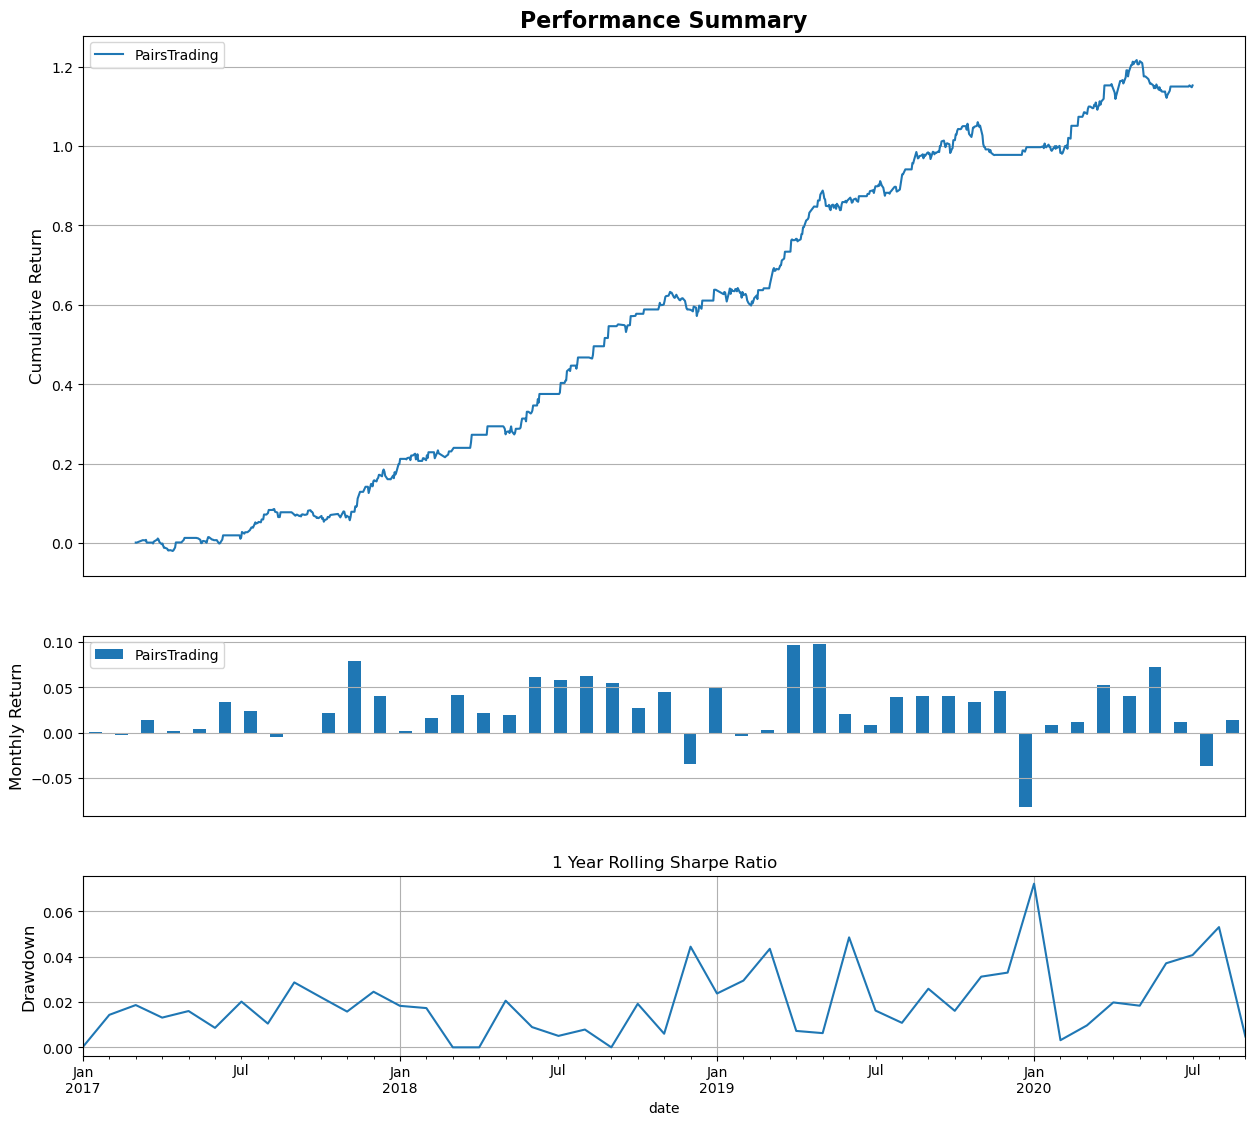

PairsTrading: 100%|██████████| 1/1 [01:46<00:00, 106.75s/it]


artificial2





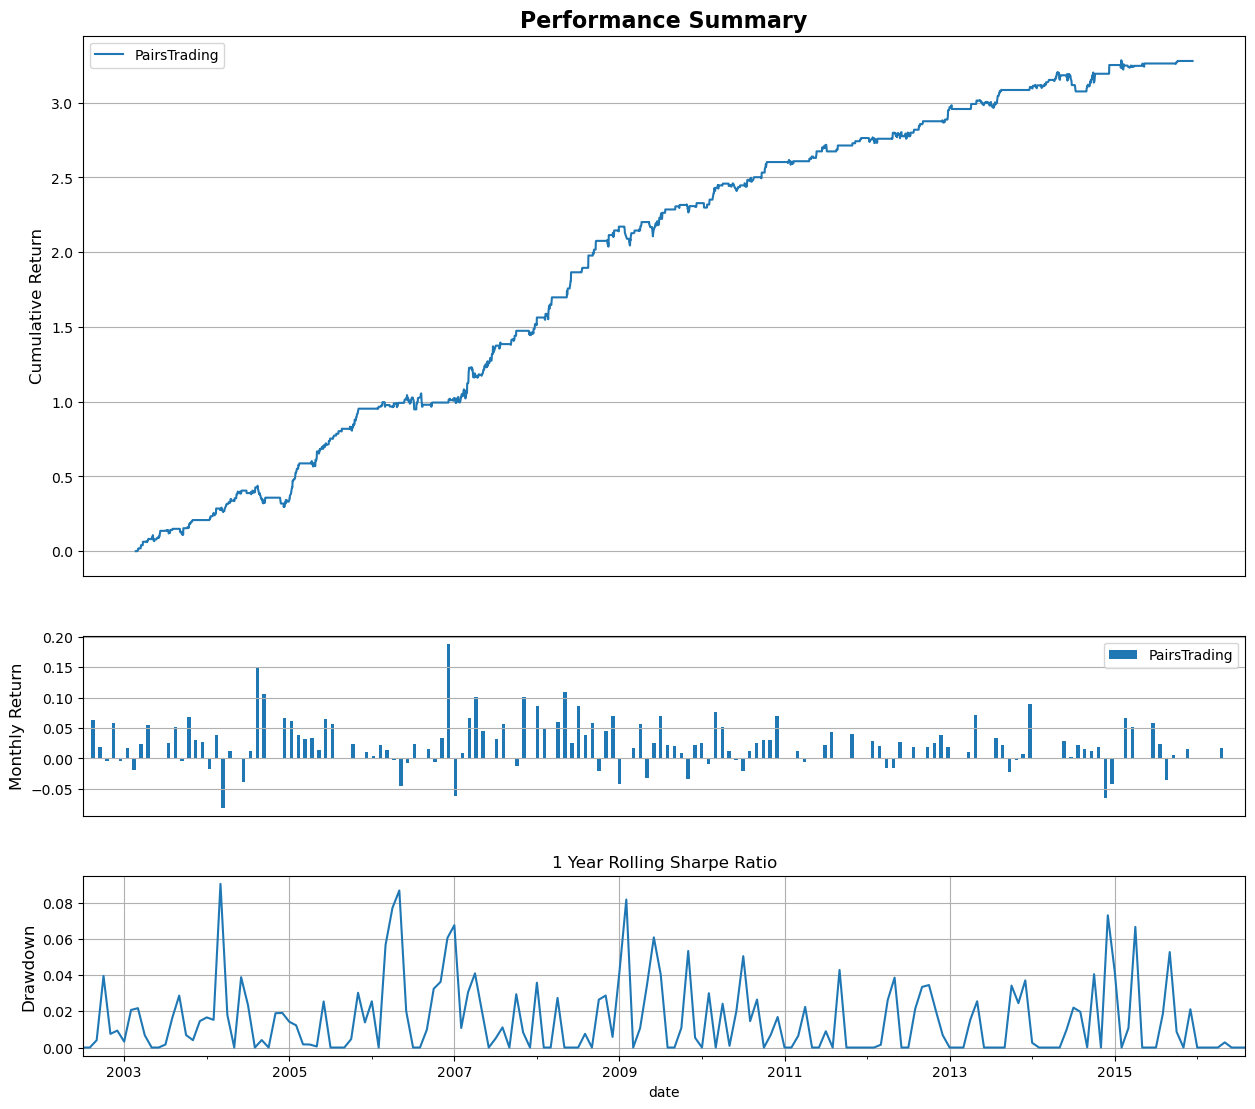

PairsTrading: 100%|██████████| 1/1 [00:45<00:00, 45.06s/it]


bonds





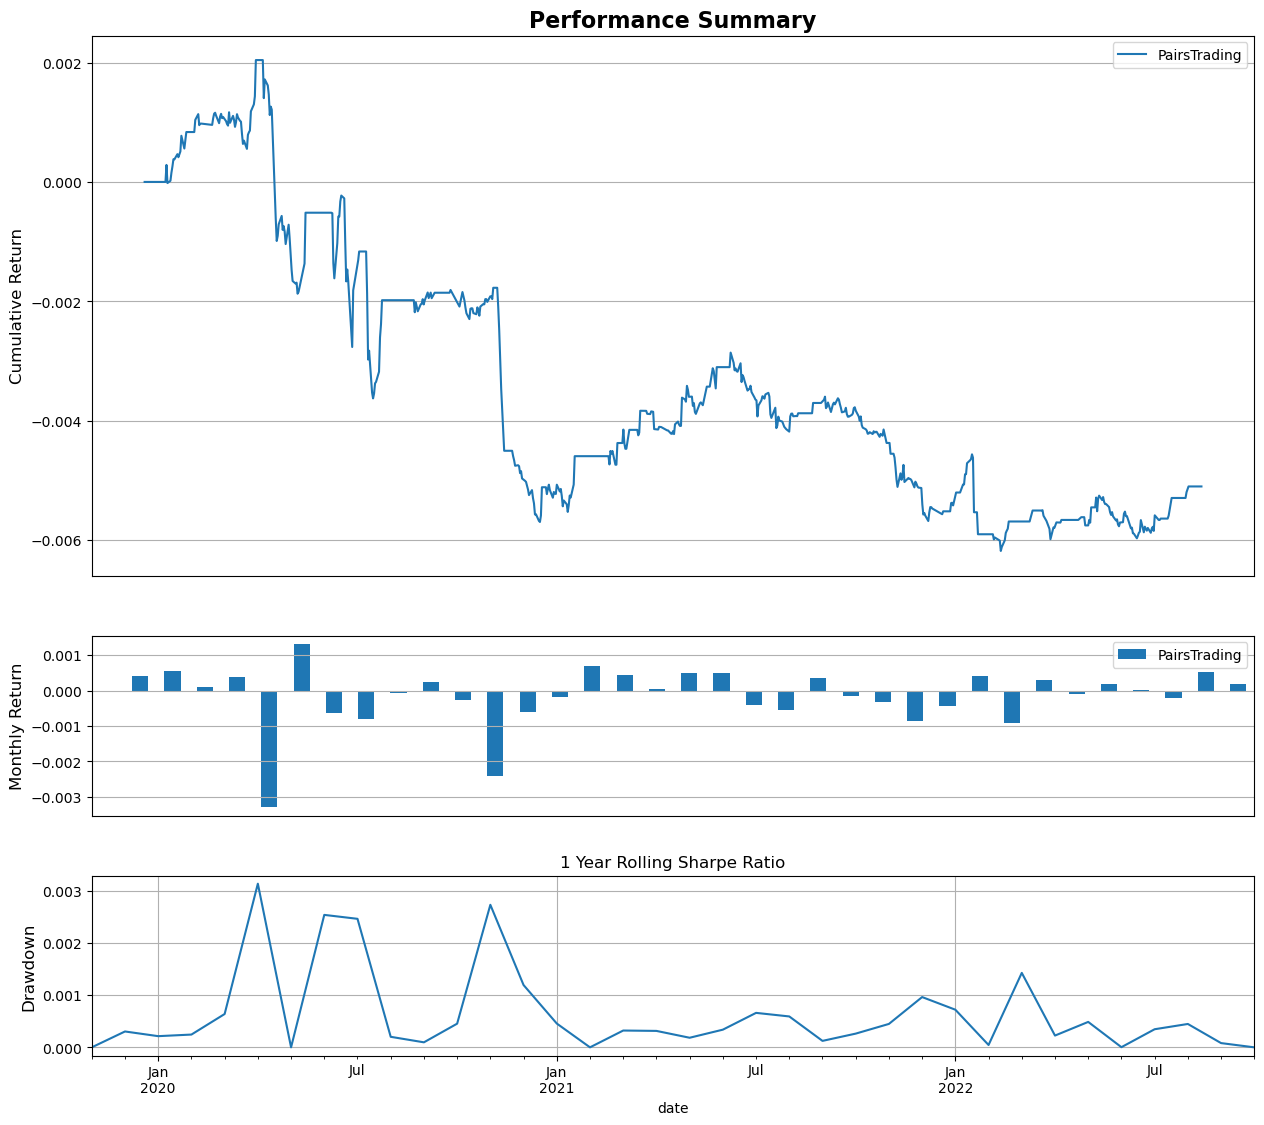

PairsTrading: 100%|██████████| 1/1 [00:33<00:00, 33.06s/it]


crypto





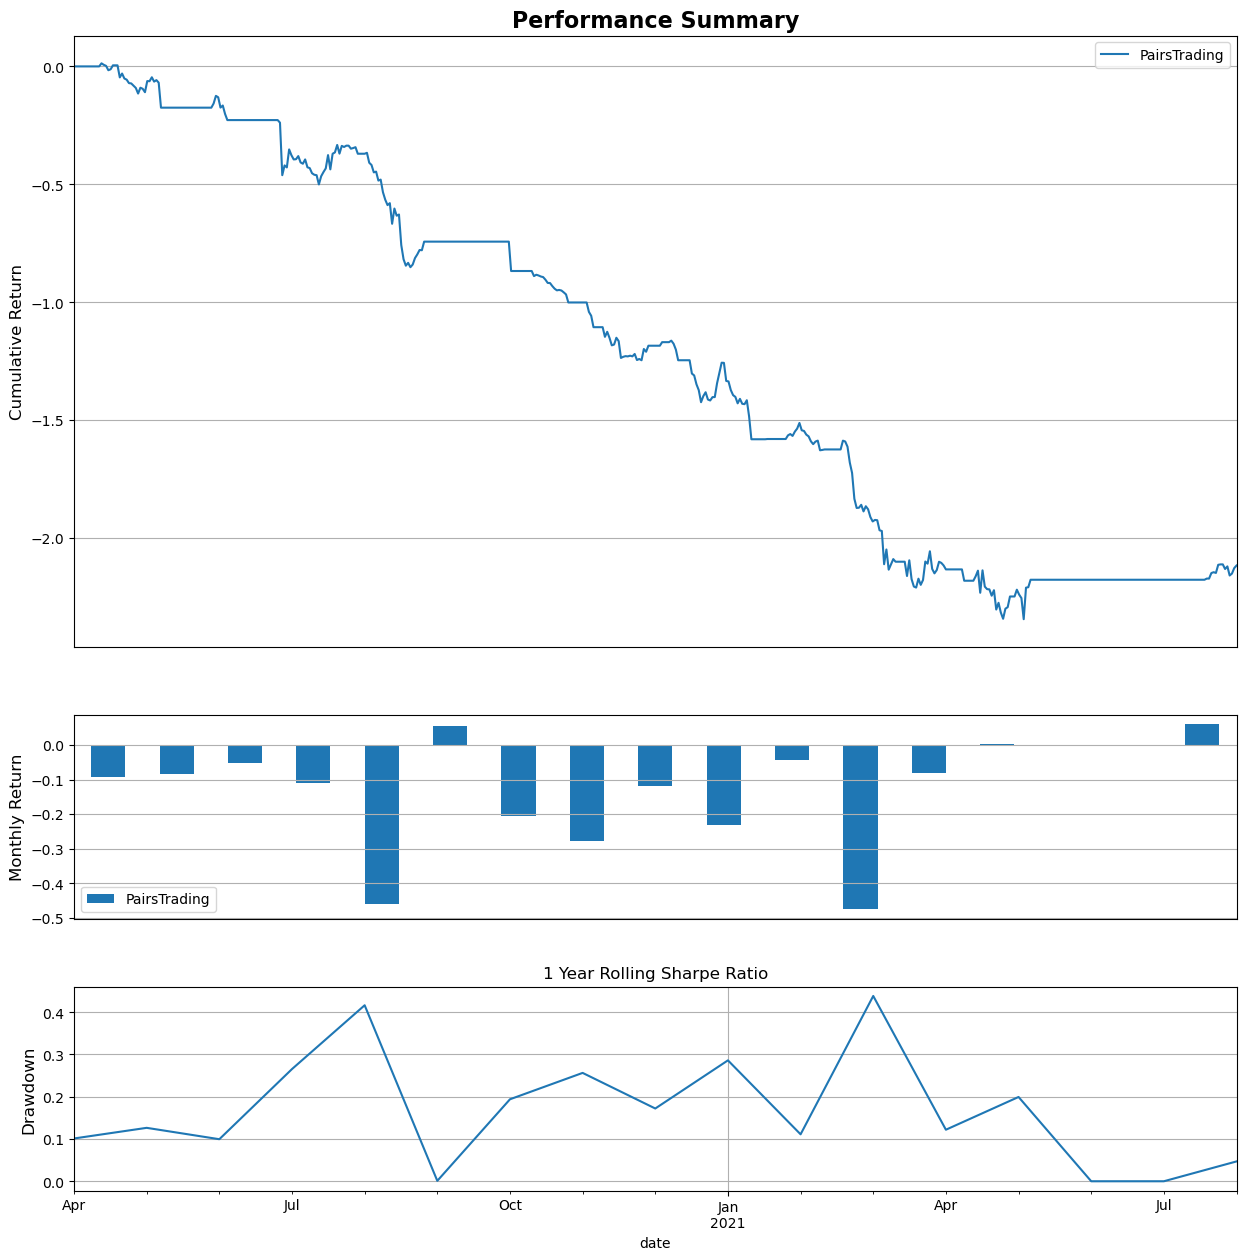

PairsTrading: 100%|██████████| 1/1 [02:27<00:00, 147.75s/it]


equity





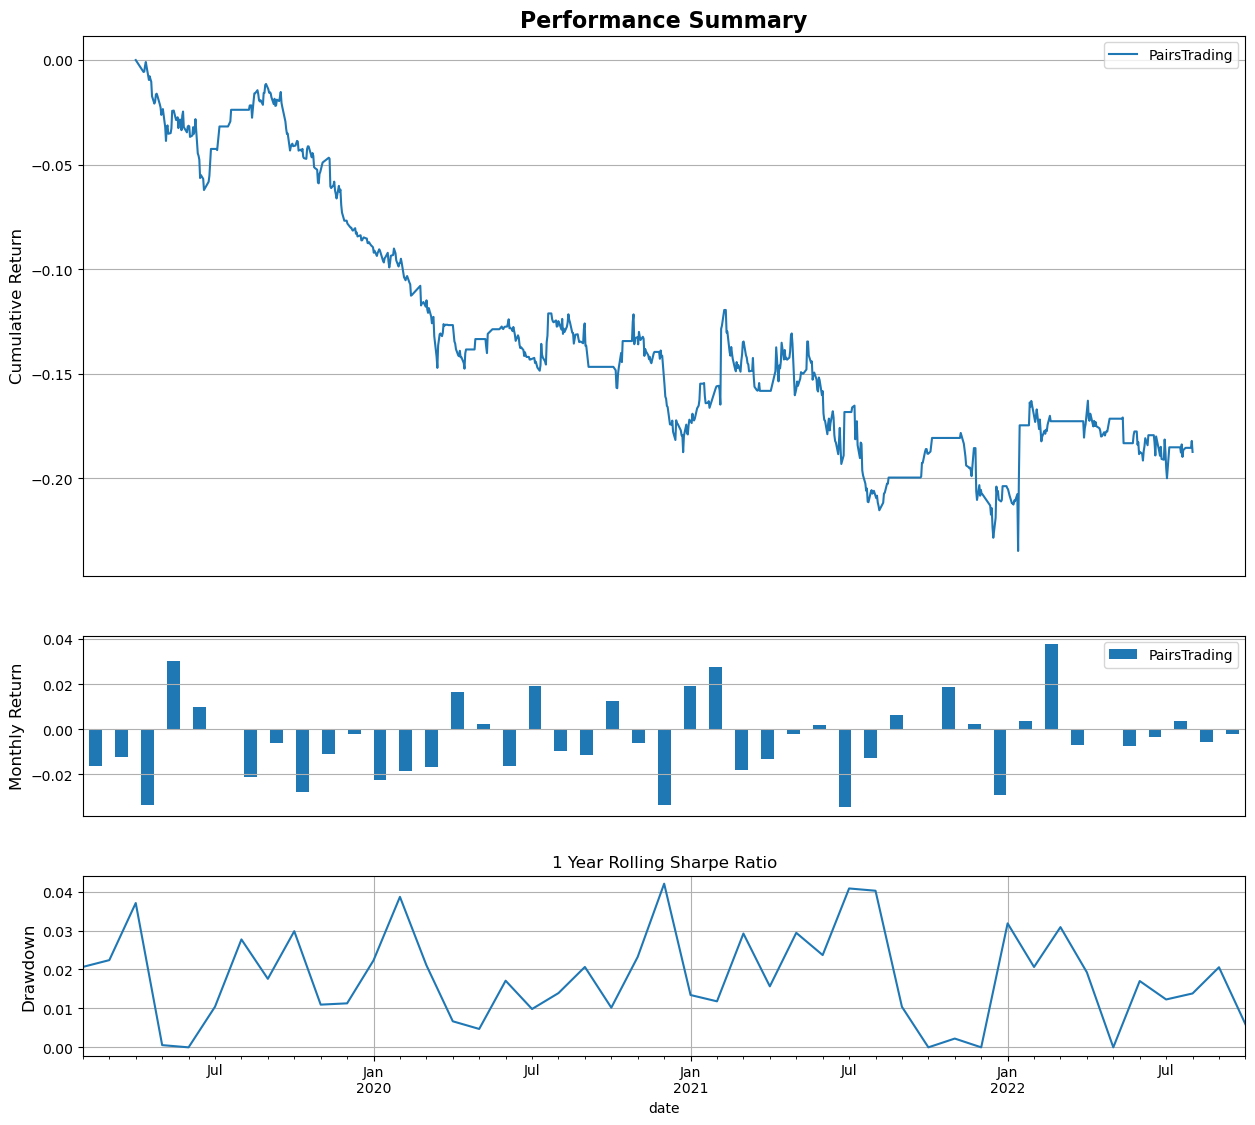

PairsTrading: 100%|██████████| 1/1 [03:10<00:00, 190.09s/it]


IndustrySector





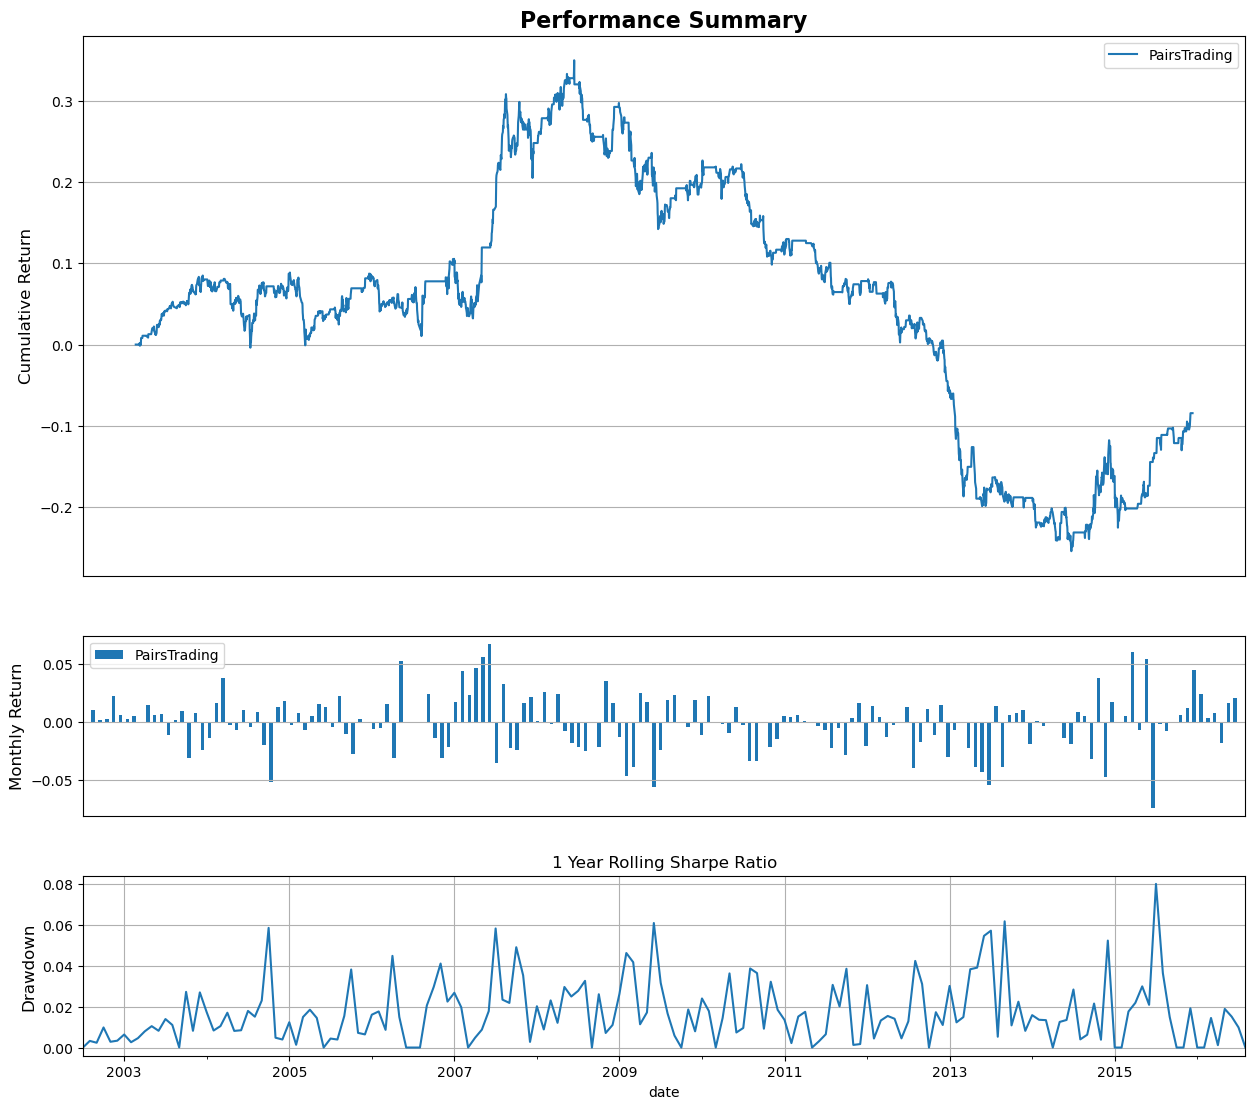

In [184]:
for i, asset_class in enumerate(market_csvs):
    df = pd.read_csv(asset_class)
    art_ret = clean_returns(df)
    dic = {'close': art_ret}
    bt = adjust_backtester(a, art_ret, dic)
    
    alphas = [PairsTrading(90, 10, 2.25, 1.75, 3.5, len(art_ret.columns))]

    returns[asset_class], holdings[asset_class] = bt.backtest(alphas, processes=None)
    print("\n\n"markets[i])
    returns[asset_class].to_csv((f"{markets[i]}_results.csv"))
    
    metrics.summary_plot(returns[asset_class], source=['PairsTrading'])

    #returns, holdings = backtester.backtest(alphas, processes=None)
    # rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    # returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()

### Exploratory Data Analysis

<AxesSubplot:xlabel='Dates'>

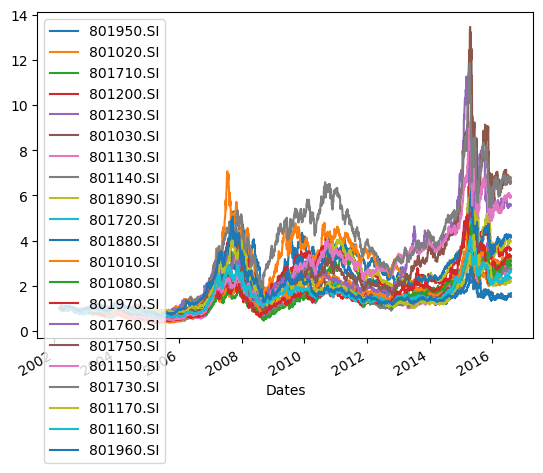

In [170]:
clean_returns(artificial2).plot()

## Testing with arbitrary starting price

okay so this didn't change anything

PairsTrading: 100%|██████████| 1/1 [00:37<00:00, 37.25s/it]




C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial1_return.csv


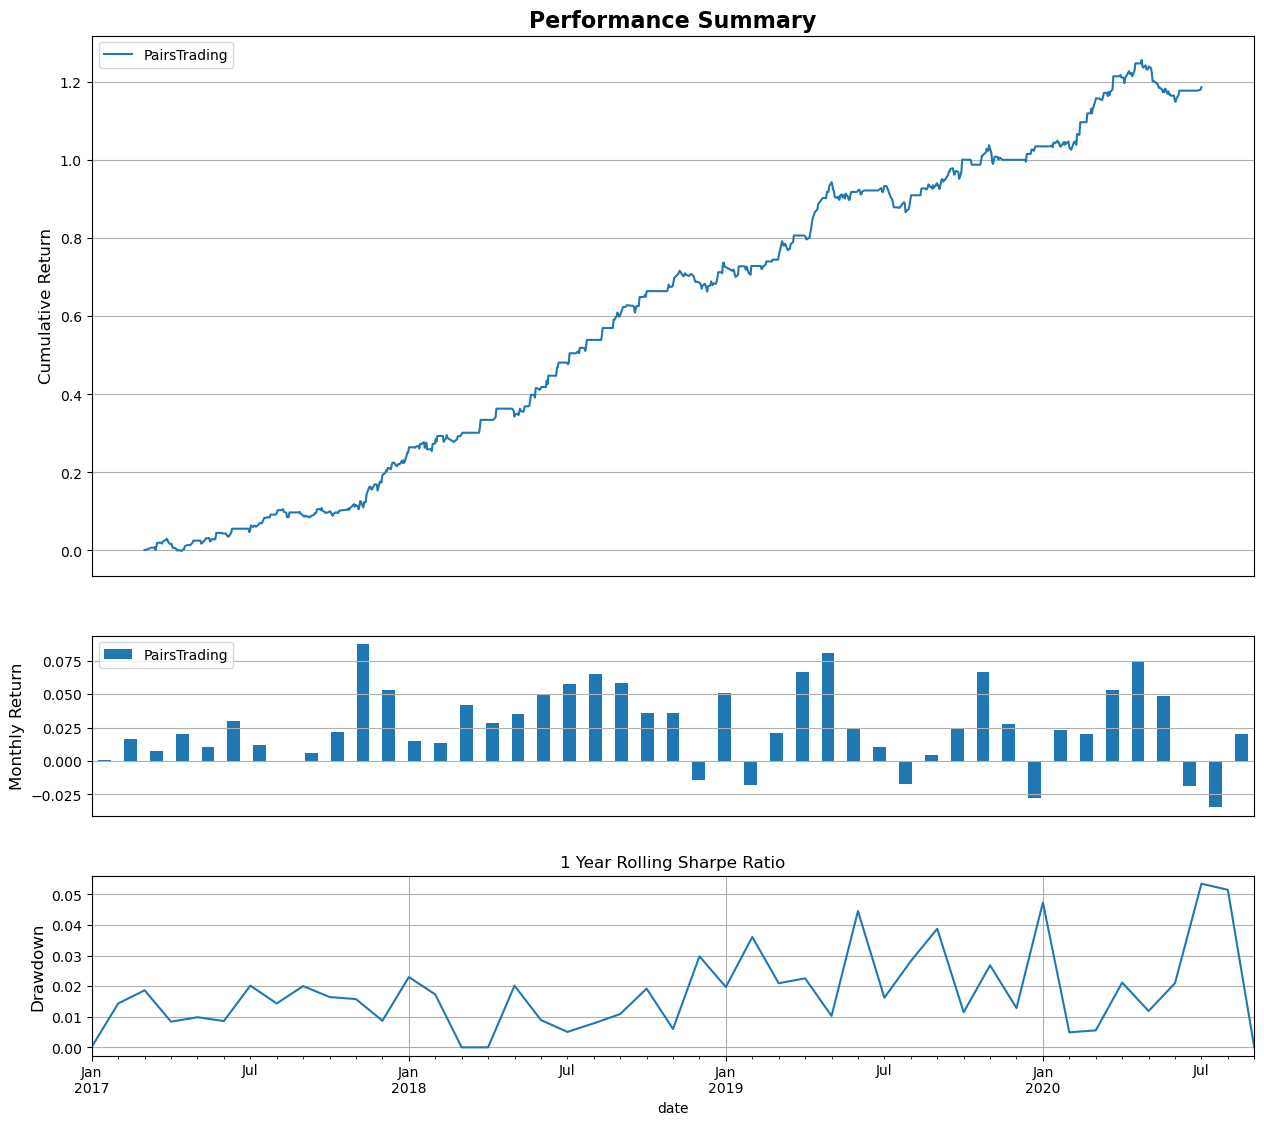

PairsTrading: 100%|██████████| 1/1 [01:24<00:00, 84.64s/it]





C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\artificial2_return.csv


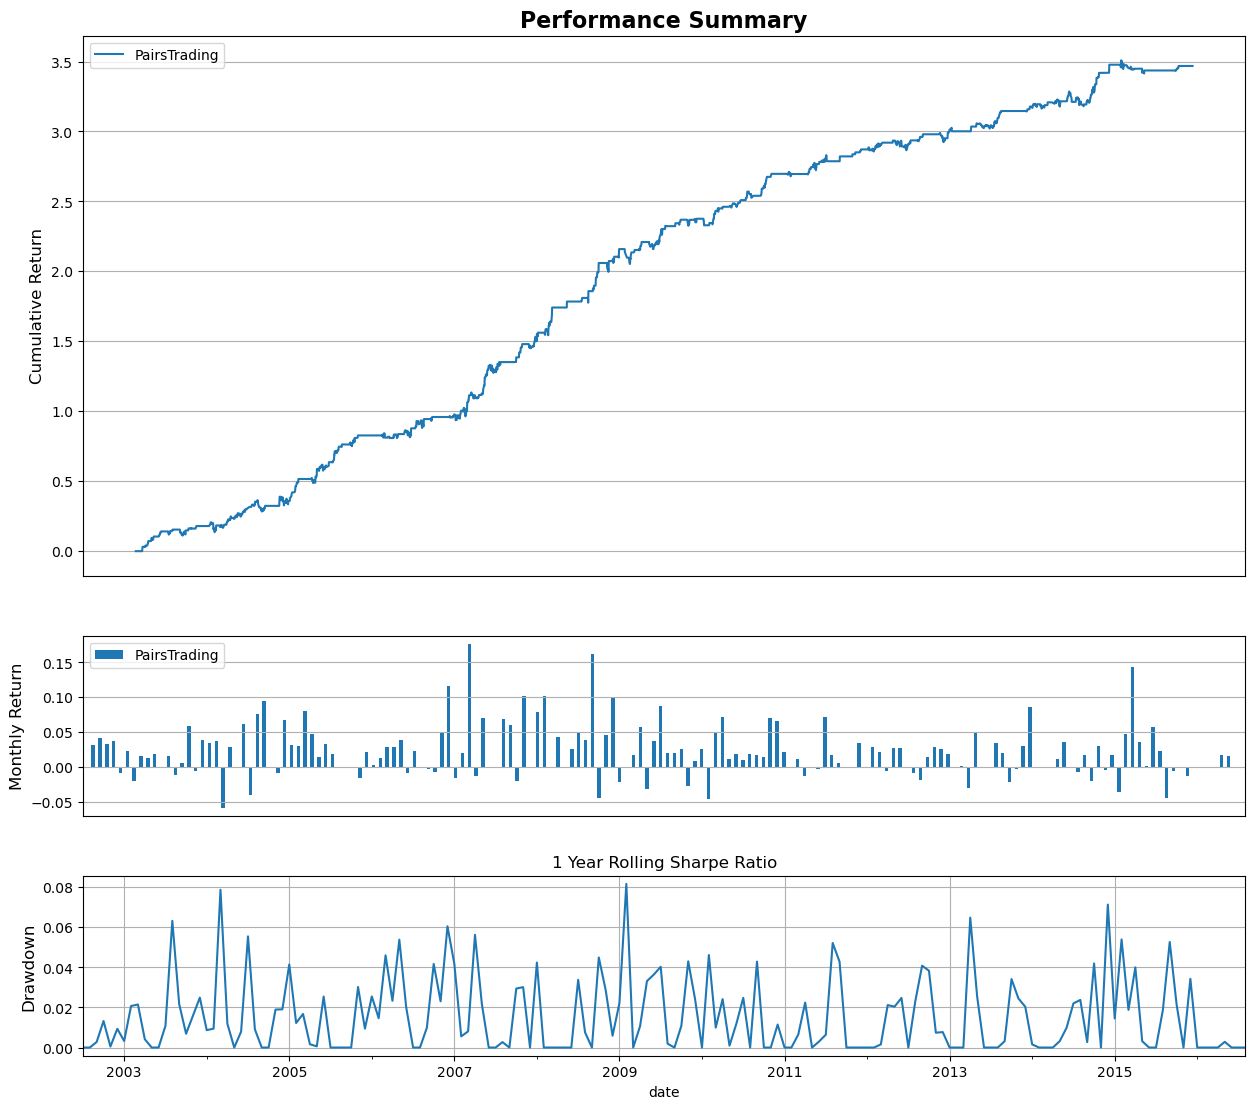

PairsTrading: 100%|██████████| 1/1 [00:46<00:00, 46.38s/it]





C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\bonds_cleaned_return.csv


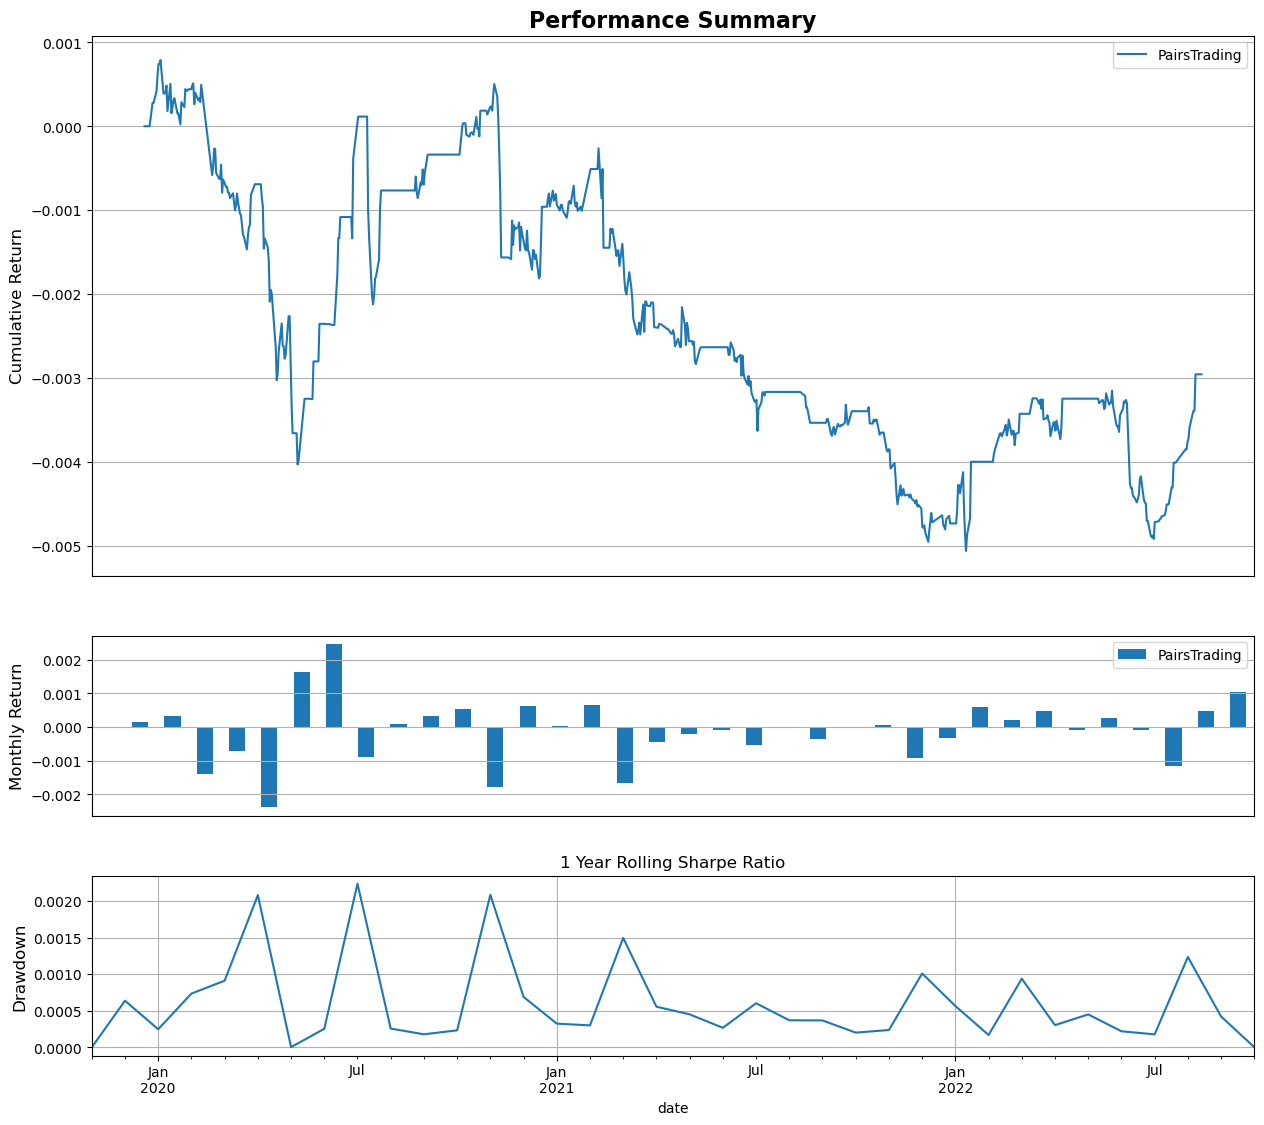

PairsTrading: 100%|██████████| 1/1 [00:32<00:00, 32.35s/it]





C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\crypto_cleaned_return.csv


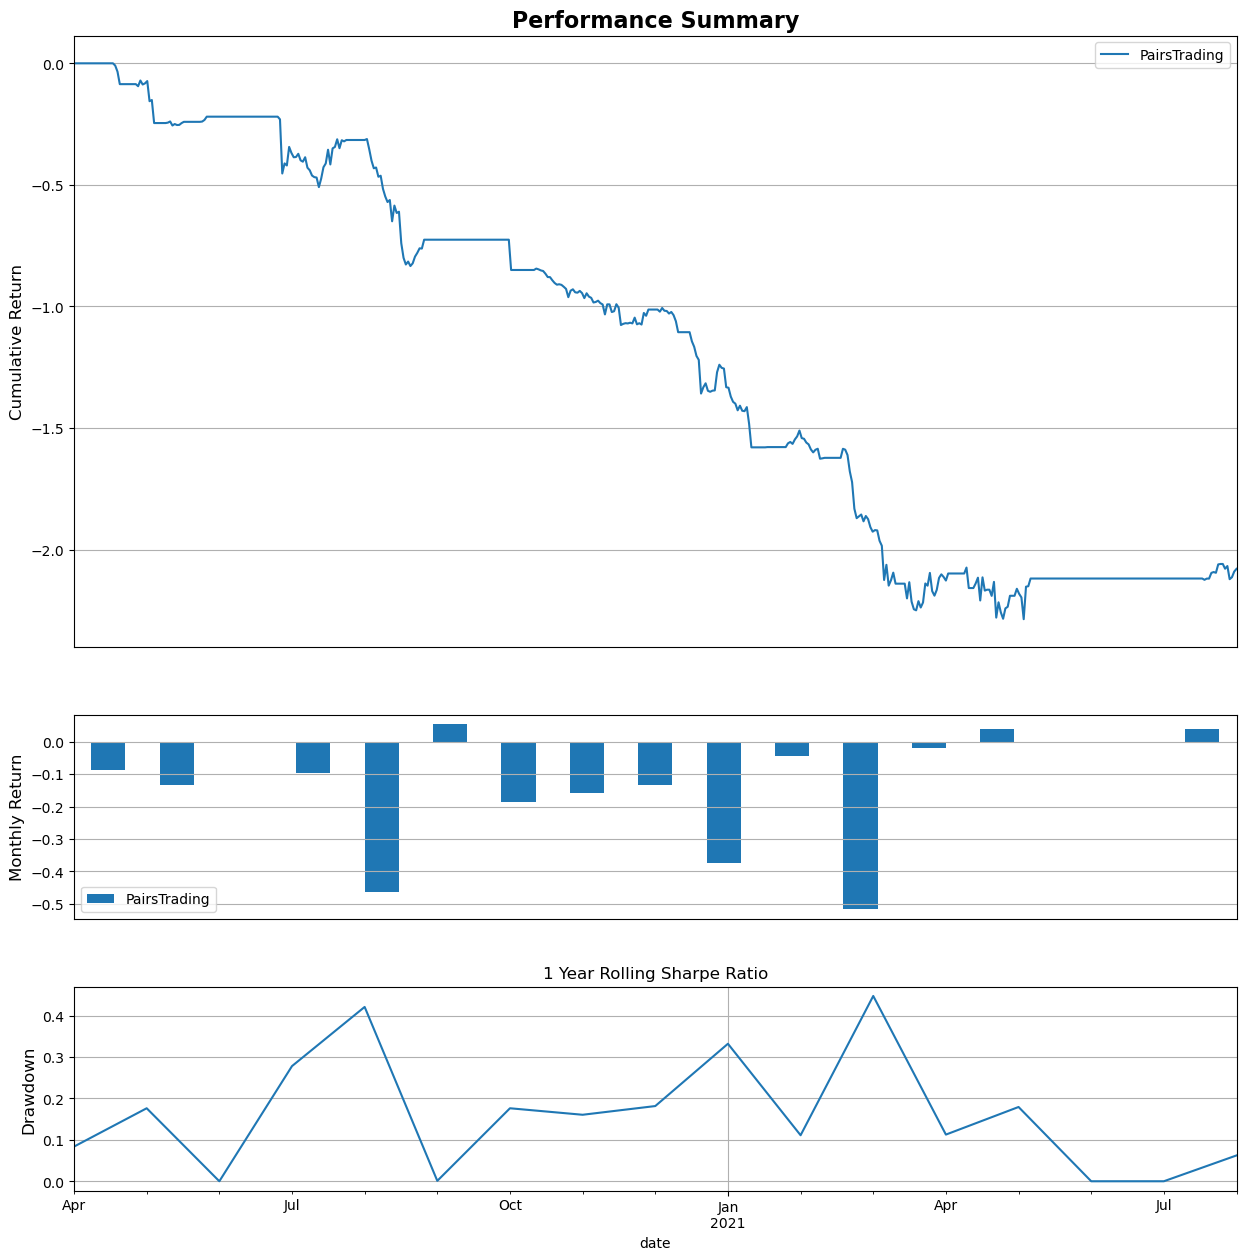

PairsTrading: 100%|██████████| 1/1 [02:30<00:00, 150.53s/it]





C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\equity_cleaned_return.csv


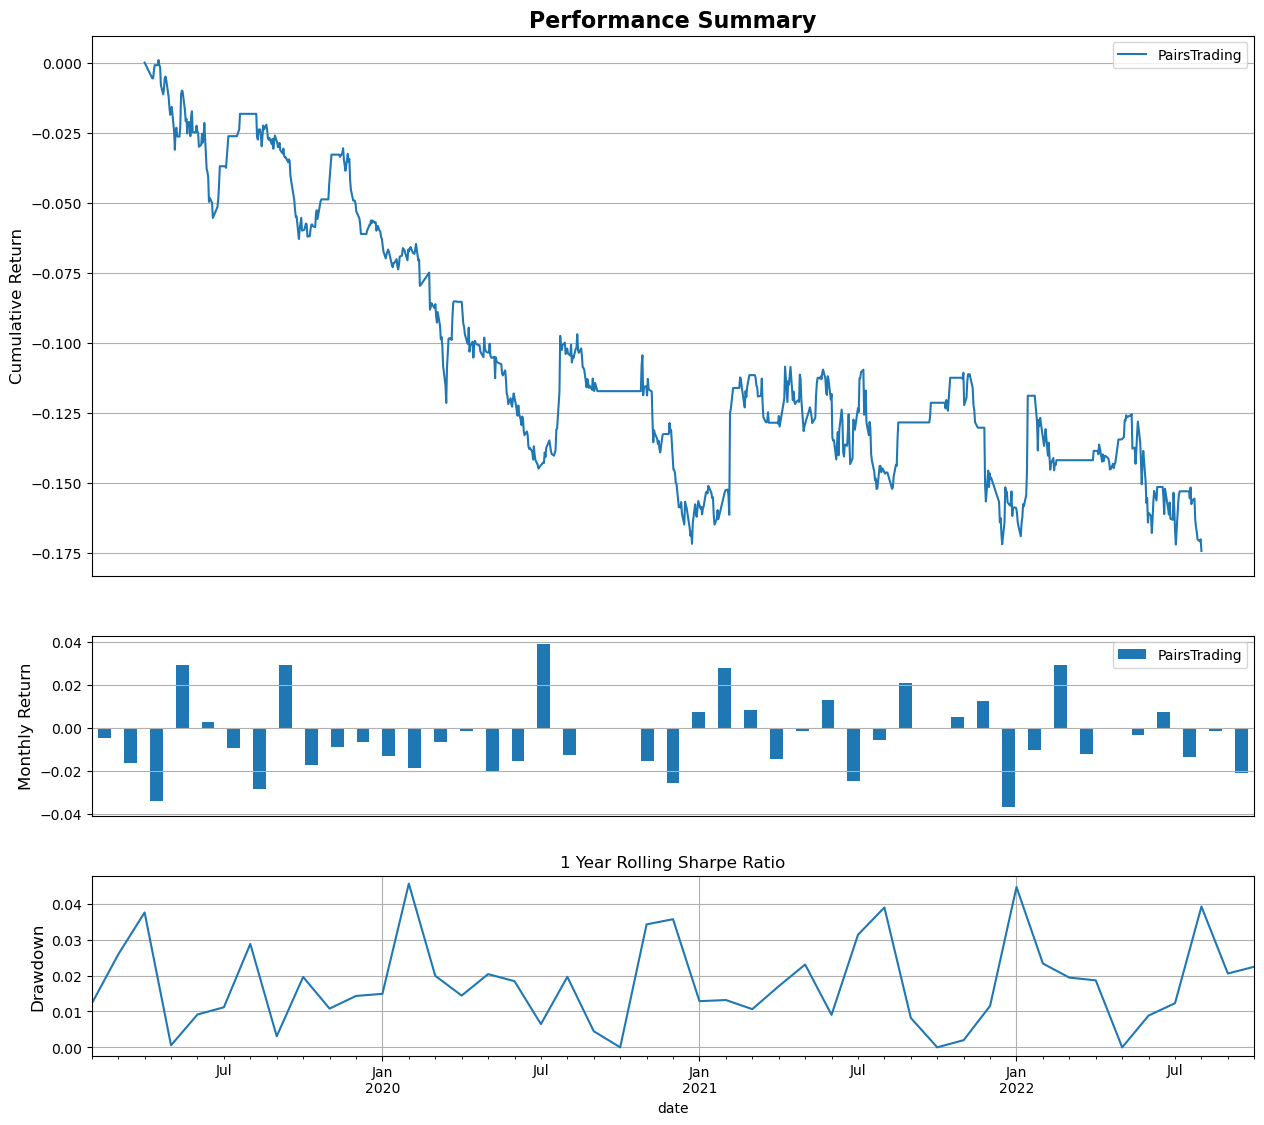

PairsTrading: 100%|██████████| 1/1 [03:03<00:00, 183.83s/it]





C:\Users\James Zhang\Desktop\sif\MultiMarketComparison\IndustrySector_cleaned_return.csv


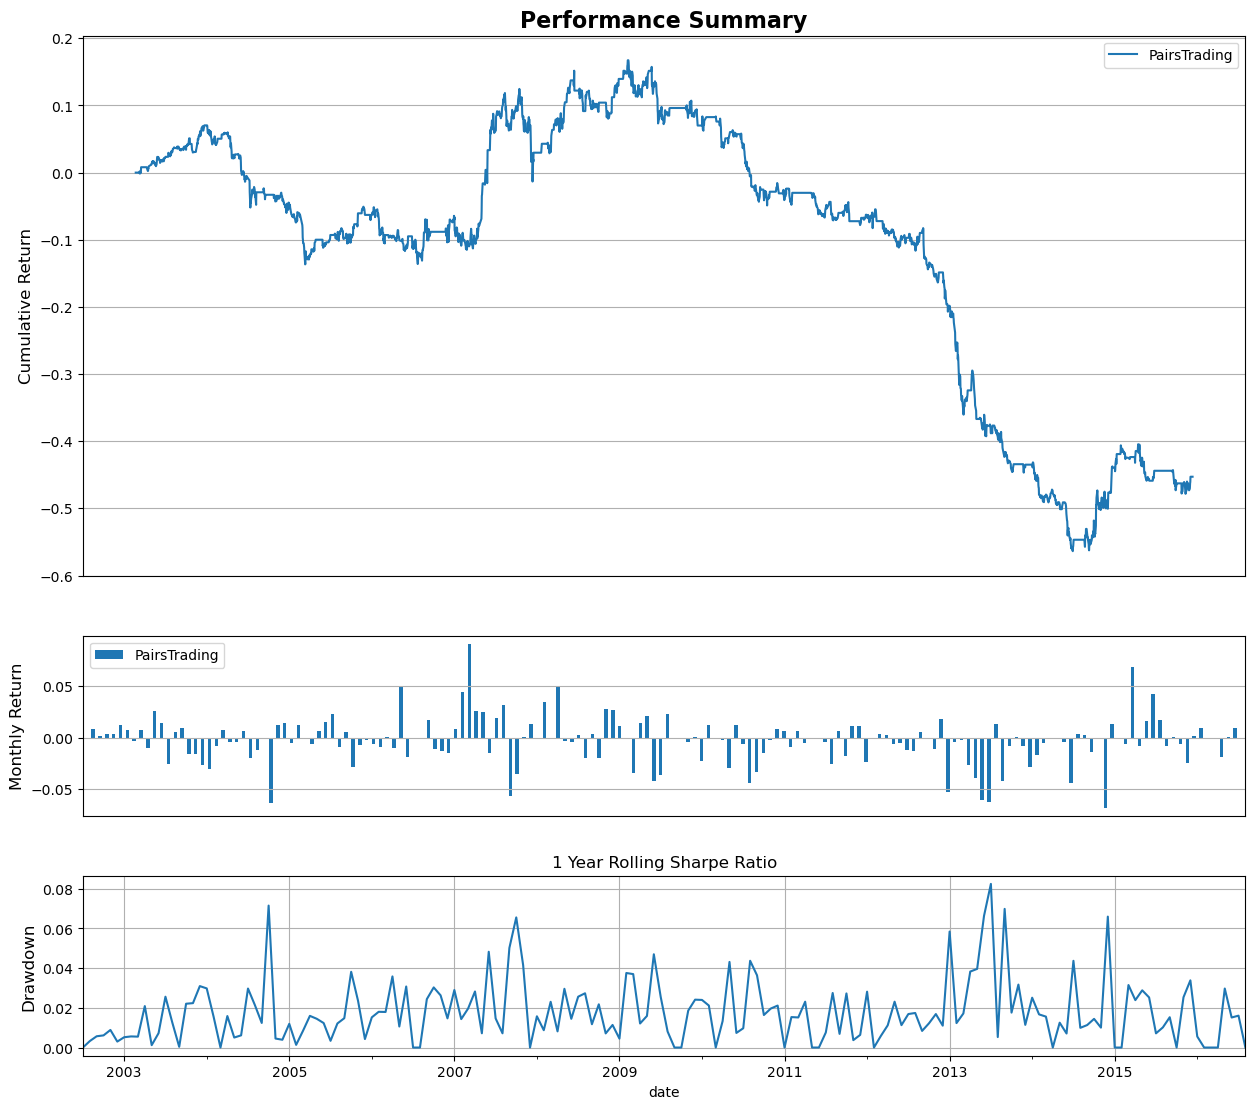

In [164]:
for asset_class in market_csvs:
    df = pd.read_csv(asset_class)
    art_ret = clean_returns2(df)
    dic = {'close': art_ret}
    bt = adjust_backtester(a, art_ret, dic)
    
    alphas = [PairsTrading(90, 10, 2.25, 1.75, 3.5, len(art_ret.columns))]

    returns[asset_class], holdings[asset_class] = bt.backtest(alphas, processes=None)
    # returns[asset_class].to_csv((asset_class + "pairs returns.csv"))
    print("\n\n")     
    print(asset_class)
    
    metrics.summary_plot(returns[asset_class], source=['PairsTrading'])

    #returns, holdings = backtester.backtest(alphas, processes=None)
    # rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    # returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()